In [0]:
# Downloading the data.

from six.moves import urllib
import os
import sys
import tarfile

!mkdir -p 'data'
data_dir = 'data/'

data_url = 'http://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz'
filename = data_url.split('/')[-1]
filepath = data_dir + data_url.split('/')[-1]

if not os.path.exists(filepath):
  def progress(count, block_size, total_size):
    sys.stdout.write('\r>> Downloading %s %.1f%%' % \
        (filename, float(count * block_size) / total_size * 100))
    sys.stdout.flush()
  filepath, _ = urllib.request.urlretrieve(data_url, filepath, progress)
  tarfile.open(filepath, 'r:gz').extractall(data_dir)

>> Downloading 17flowers.tgz 100.0%

In [0]:
# Creating a larger dataset using data augmentation.

from PIL import Image
from os import listdir
from os.path import isfile, join
import numpy as np
import numpy.random as rnd

img_dir = data_dir + 'jpg/'

img_files = [join(img_dir, f)
             for f in listdir(img_dir) if isfile(join(img_dir, f))]

data = []
for f in img_files:
  if f.split('.')[-1] != 'jpg':
    continue
  img = Image.open(f)
  imgs = [img.rotate(10.0 * (rnd.random() - 0.5)) for _ in range(5)]
  all_imgs = []
  for img in imgs:
    w, h = img.size
    if w > h:
      all_imgs.append(img.crop(((w - h) // 2, 0, h, h)))
      all_imgs.append(img.crop((w - h, 0, h, h)))
      all_imgs.append(img.crop((0, 0, h, h)))
    else:
      all_imgs.append(img.crop((0, (h - w) // 2, w, w)))
      all_imgs.append(img.crop((0, h - w, w, w)))
      all_imgs.append(img.crop((0, 0, w, w)))
  for img in all_imgs:
    img = img.resize((64, 64))
    data.append(np.asarray(img) / 255)
    data.append(np.asarray(img.transpose(Image.FLIP_LEFT_RIGHT)) / 255)
data = np.array(data, dtype=np.float32)

In [0]:
data.shape

(40800, 64, 64, 3)

In [0]:
import matplotlib.pyplot as plt

def plot_image(img, shape=(64, 64, 3)):
  plt.imshow(img.reshape(shape), cmap='gray', interpolation='nearest')
  plt.axis('off')

Let's look at som sample images from the test set.

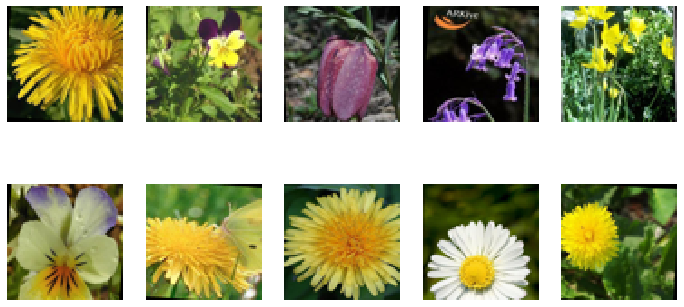

In [0]:
# Plotting some sample data.

rnd_idx = rnd.permutation(len(data))
fig = plt.figure(figsize=(12, 6))

for i, img in enumerate(data[rnd_idx[:10]]):
  plt.subplot(2, 5, i + 1)
  plot_image(img)
plt.show()

## Building a WGAN-GP to Generate New Images

Below we will use Keras to create a [WGAN-GP](https://arxiv.org/pdf/1704.00028.pdf) model to make new images of flowers using the 40,000 training images.

In [0]:
!pip install tensorflow-gpu

In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
from tensorflow.keras.layers import (Input, Conv2D, LeakyReLU, Activation,
                                     Dropout, Flatten, Dense, Reshape,
                                     BatchNormalization, UpSampling2D,
                                     Conv2DTranspose, Lambda)
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
import numpy as np
import tensorflow.keras.backend as K
from functools import partial
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow as tf


tf.logging.set_verbosity(tf.logging.ERROR)


def get_activation(activation_fn_name):
  """Get the activation layer from the name of the function."""
  if activation_fn_name == 'leaky_relu':
    return LeakyReLU(alpha=0.2)
  return Activation(activation_fn_name)


def set_trainable(model, value):
  """Set each layer of a model as trainable."""
  model.trainable = value
  for l in model.layers:
    l.trainable = value


def get_optimizer(optimizer_name, learning_rate):
  """Get an optimizer by name."""
  if optimizer_name == 'adam':
    return Adam(lr=learning_rate)
  if optimizer_name == 'rmsprop':
    return RMSprop(lr=learning_rate)
  return Adam(lr=learning_rate)


def wasserstein_loss(y_true, y_pred):
  """Wasserstein loss function."""
  return -K.mean(y_true * y_pred)


class WGANGP(object):
  """Implementation of a WGAN-GP using Keras."""

  def __init__(self, input_shape, critic_conv_filters, critic_conv_kernel_size,
               critic_conv_strides, critic_activation, critic_dropout_rate,
               critic_learning_rate, generator_initial_dense_layer_shape,
               generator_upsample, generator_conv_filters,
               generator_conv_kernel_size, generator_conv_strides,
               generator_batch_norm_momentum, generator_activation,
               generator_dropout_rate, generator_learning_rate, optimizer,
               gradient_weight, z_dim, batch_size):
    # Build the critic.
    critic_input = Input(shape=input_shape, name='critic_input')
    x = critic_input
    weight_init = RandomNormal(mean=0.0, stddev=0.02)
    for i in range(len(critic_conv_filters)):
      x = Conv2D(filters=critic_conv_filters[i],
                 kernel_size=critic_conv_kernel_size[i],
                 strides=critic_conv_strides[i], padding='same',
                 kernel_initializer=weight_init,
                 name='critic_conv_{}'.format(i))(x)
      x = get_activation(critic_activation)(x)
      if critic_dropout_rate:
        x = Dropout(rate=critic_dropout_rate)(x)
    x = Flatten()(x)
    critic_output = Dense(1, activation=None, kernel_initializer=weight_init)(x)
    self.critic = Model(critic_input, critic_output)

    self.z_dim = z_dim

    # Build the generator.
    generator_input = Input(shape=(z_dim,), name='generator_input')
    x = generator_input
    x = Dense(np.prod(generator_initial_dense_layer_shape),
              kernel_initializer=weight_init)(x)
    if generator_batch_norm_momentum:
      x = BatchNormalization(momentum=generator_batch_norm_momentum)(x)
    x = get_activation(generator_activation)(x)
    x = Reshape(target_shape=generator_initial_dense_layer_shape)(x)
    if generator_dropout_rate:
      x = Dropout(rate=generator_dropout_rate)(x)
    for i in range(len(generator_upsample)):
      if generator_upsample == 2:
        x = UpSampling2D()(x)
        x = Conv2D(filters=generator_conv_filters[i],
                   kernel_size=generator_conv_kernel_size[i],
                   strides=generator_conv_strides[i], padding='same',
                   kernel_initializer=weight_init,
                   name='generator_conv_{}'.format(i))(x)
      else:
        x = Conv2DTranspose(filters=generator_conv_filters[i],
                            kernel_size=generator_conv_kernel_size[i],
                            strides=generator_conv_strides[i], padding='same',
                            kernel_initializer=weight_init,
                            name='generator_conv_{}'.format(i))(x)
      if i == (len(generator_upsample) - 1):
        break
      if generator_batch_norm_momentum:
        x = BatchNormalization(momentum=generator_batch_norm_momentum)(x)
      x = get_activation(generator_activation)(x)
    generator_output = Activation('tanh')(x)
    self.generator = Model(generator_input, generator_output)

    # Compile the critic.
    set_trainable(self.generator, False)

    real_img = Input(shape=input_shape)
    z_disc = Input(shape=(z_dim,))
    fake_img = self.generator(z_disc)

    real = self.critic(real_img)
    fake = self.critic(fake_img)

    def interpolate_inputs(inputs):
      alpha = K.random_uniform((batch_size, 1, 1, 1))
      return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

    self.interpolated_img = Lambda(interpolate_inputs)([real_img, fake_img])
    interpolated_prediction = self.critic(self.interpolated_img)

    self.critic_model = Model(inputs=[real_img, z_disc],
                              outputs=[real, fake, interpolated_prediction])

    self.critic_model.compile(
        loss=[wasserstein_loss, wasserstein_loss, self.gradient_penalty_loss],
        optimizer=get_optimizer(optimizer, critic_learning_rate),
        loss_weights=[1, 1, gradient_weight])

    set_trainable(self.generator, True)

    # Compile the generator.
    set_trainable(self.critic, False)

    model_input = Input(shape=(z_dim,))
    model_output = self.critic(self.generator(model_input))
    self.model = Model(model_input, model_output)
    self.model.compile(
        loss=wasserstein_loss,
        optimizer=get_optimizer(optimizer, generator_learning_rate))

  def gradient_penalty_loss(self, y_true, y_pred):
    """Compute the GP loss using interpolations of real and fake images."""
    gradients = K.gradients(y_pred, self.interpolated_img)[0]
    assert gradients is not None
    gradients_sqr = K.square(gradients)
    gradients_l2_norm = K.sqrt(
        K.sum(gradients_sqr, axis=np.arange(1, len(gradients_sqr.shape))))
    return K.mean(K.square(1 - gradients_l2_norm))

  def train_critic(self, X_train, batch_size):
    """Train the critic."""
    real = np.ones((batch_size, 1), dtype=np.float32)
    fake = -np.ones((batch_size, 1), dtype=np.float32)
    dummy = np.zeros((batch_size, 1), dtype=np.float32)
    rand_idx = np.random.randint(0, len(X_train), size=(batch_size,))
    X_real = X_train[rand_idx]
    noise = np.random.normal(0.0, 1.0, (batch_size, self.z_dim))
    return self.critic_model.train_on_batch([X_real, noise],
                                            [real, fake, dummy])
    
  def train_generator(self, batch_size):
    """Train the generator model."""
    real = np.ones((batch_size, 1), dtype=np.float32)
    noise = np.random.normal(0, 1, (batch_size, self.z_dim))
    return self.model.train_on_batch(noise, real)

  def train(self, X_train, batch_size, epochs, n_critic, print_every_n_epochs,
            checkpoint_path, save_every_n_epochs, initial_epoch):
    """Train the WGAN-GP model using a data generator."""
    if checkpoint_path and initial_epoch > 0:
      self.model.load_weights(
          checkpoint_path + 'model_weights_{}.hdf5'.format(initial_epoch))
    for epoch in range(initial_epoch + 1, epochs + 1):
      for _ in range(n_critic):
        d_loss = self.train_critic(X_train, batch_size)
      g_loss = self.train_generator(batch_size)
      if epoch % print_every_n_epochs == 0:
        print('Epoch: {}'.format(epoch))
        print('D Loss: {:04f}'.format(d_loss[0]))
        print('G Loss: {:04f}'.format(g_loss))
      if epoch % save_every_n_epochs == 0 and checkpoint_path:
        print('Saving after epoch: {}'.format(epoch))
        self.model.save_weights(checkpoint_path + 'model_weights.hdf5')
        self.model.save_weights(
            checkpoint_path + 'model_weights_{}.hdf5'.format(epoch))

In [0]:
IMAGE_SIZE = 64
BATCH_SIZE = 64

wgangp = WGANGP(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                critic_conv_filters=(64, 128, 256, 512),
                critic_conv_kernel_size=(5, 5, 5, 5),
                critic_conv_strides=(2, 2, 2, 2),
                critic_activation='leaky_relu',
                critic_dropout_rate=None,
                critic_learning_rate=0.0002,
                generator_initial_dense_layer_shape=(4, 4, 64),
                generator_upsample=(1, 1, 1, 1),
                generator_conv_filters=(256, 128, 64, 3),
                generator_conv_kernel_size=(5, 5, 5, 5),
                generator_conv_strides=(2, 2, 2, 2),
                generator_batch_norm_momentum=0.9,
                generator_activation='leaky_relu',
                generator_dropout_rate=None,
                generator_learning_rate=0.0002,
                optimizer='adam',
                gradient_weight=10,
                z_dim=100,
                batch_size=BATCH_SIZE)

In [0]:
wgangp.critic.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    [(None, 64, 64, 3)]       0         
_________________________________________________________________
critic_conv_0 (Conv2D)       multiple                  4864      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      multiple                  0         
_________________________________________________________________
critic_conv_1 (Conv2D)       multiple                  204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    multiple                  0         
_________________________________________________________________
critic_conv_2 (Conv2D)       multiple                  819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    multiple                  0     

In [0]:
wgangp.generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              103424    
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 64)          0         
_________________________________________________________________
generator_conv_0 (Conv2DTran (None, 8, 8, 256)         409856    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024

In [0]:
# Mount Google drive to load the data and to save the model weights.
from google.colab import drive

drive.mount('/content/gdrive/')
checkpoint_path = '/content/gdrive/My Drive/oxfordwgan/'

Let's train the model for 30,000 training batches and see how it performs.

In [0]:
wgangp.train(data, batch_size=BATCH_SIZE, epochs=30000, n_critic=5,
             print_every_n_epochs=10, checkpoint_path=checkpoint_path,
             save_every_n_epochs=100, initial_epoch=25000)

We see after 30,000 training batches, the model is able to mostly create pretty convincing images of flowers. Some images still do not look real, but others could fool a human observer.

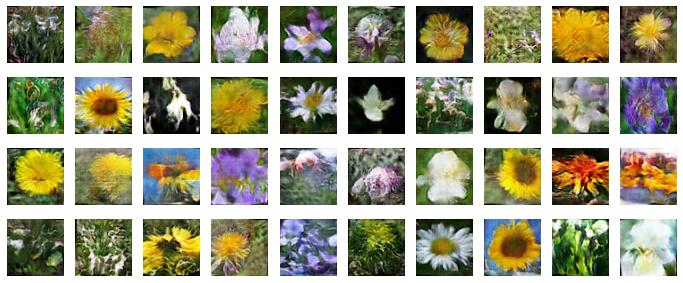

In [0]:
wgangp.model.load_weights(
    checkpoint_path + 'model_weights_{}.hdf5'.format(30000))

n_to_show = 40
n_rows = 4

fig = plt.figure(figsize=(12, 5))

for i in range(n_to_show):
  x = wgangp.generator.predict(
      np.random.normal(0.0, 1.0, size=(1, wgangp.z_dim)))[0]
  x = np.clip(x, 0, 1)
  ax = fig.add_subplot(n_rows, n_to_show // n_rows, i + 1)
  ax.axis('off')
  ax.imshow(x.squeeze(), interpolation='antialiased')